# TP Modulation - Transmission en bande de base sur un canal idéal
vincent.mazet@unistra.fr, 04/2021

In [1]:
import numpy as np
import comnumfip as cnf
import scipy.signal as signal
import scipy.spatial.distance as dist
import matplotlib.pyplot as plt

np.seterr(divide = 'ignore');

In [2]:
def myplot(ax, t, x, ylabel, title, sample_period=None, threshold=None, decoded=None, actual=None):
    
    ax.plot(t, x)
    ax.set_ylabel(ylabel)
    ax.set_title(f"{title}")
    
    if sample_period is not None:
        
        # Nombre d'erreurs
        err = dist.hamming(actual,decoded)*N
        
        # Pourcentage d'erreur
        ter = err/N
        
        # BER (Bit Error Rate)
        ber = np.log10(err/N)
        
        # Seuils
        ax.axhline(threshold, color="tab:red")
        
        # Échantillons
        L = 100
        idx = range(int(L/2), len(x), L)
        ax.plot(t[idx], x[idx], marker='o', markerfacecolor="tab:red", markeredgecolor="w", linestyle="none")
        
        # Code obtenu
        yy = ax.get_ylim()
        y0, yd = yy[0], (yy[1]-yy[0])/10
        for n in range(M):
            color = "tab:green" if decoded[n] == actual[n] else "tab:red"
            ax.text(n+.5, y0-yd, decoded[n], fontsize=16, color=color)
        ax.set_ylim([y0-2*yd, yy[1]])

        # Titre
        ax.set_title(f"{title} : {ter*100:.2f} %")

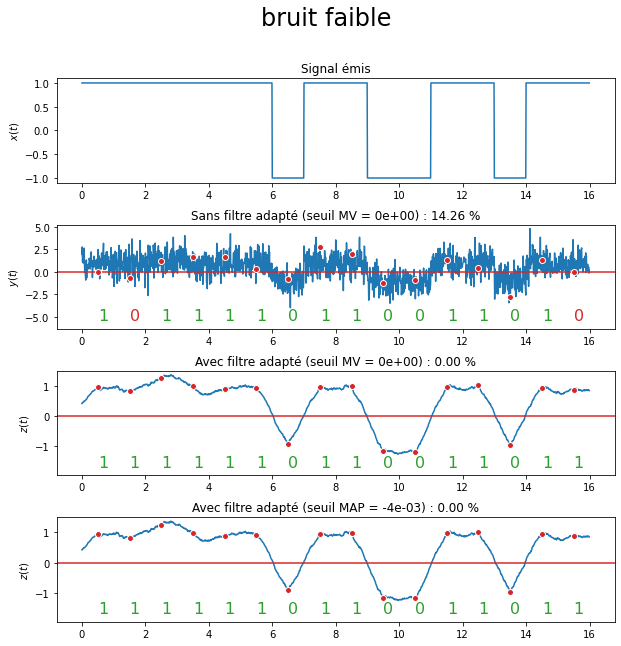

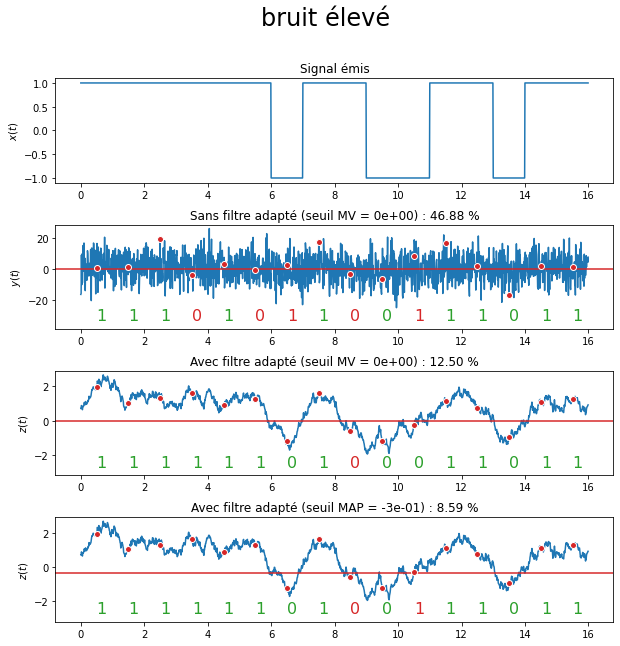

In [3]:
# Séquence binaire aléatoire
N = 512
p = 0.8
c = cnf.randmary(N,[1-p, p])

# Amplitude et durée de la forme d'onde
V, T = 1, 1

# Nombre d'échantillons dans un symbole
L = 100

# Modulation
t, xfull = cnf.mod_d(c, V, T)

# Deux niveaux de bruit
for sig in [1, 8]:
    
    x = xfull.copy()
    
    # Canal idéal
    fc = np.inf
    y = cnf.channel(x,fc,sig,T)
    
    # Filtre adapté
    g = np.ones(L)/L
    z = np.convolve(y, g, "same")
    
    # Seuil MV
    Smv = 0
    
    # Seuil MAP
    # Estimation de la variance de b~ par émission d'un signal x nul et estimation de la variance du signal z
    x0 = np.zeros(int(1e3))
    y0 = cnf.channel(x0,fc,sig,T)
    z0 = np.convolve(y0, g, "same")
    zsig = np.std(z0)
    A0, A1 = -V, V
    Smap = ( A0**2 - A1**2 + 2*zsig**2*np.log(p/(1-p)) ) / (2*(A0-A1))
    
    # Nombre de symboles pour l'affichage
    M = 16
    nmax = M*L
    
    # Figure
    fig, axs = plt.subplots(4,1,figsize=(10,10))
    fig.suptitle("bruit faible" if sig==1 else "bruit élevé", fontsize=24)
    plt.subplots_adjust(hspace=0.4)
    
    # Signal émis
    myplot(axs[0], t[:nmax], x[:nmax], ylabel="$x(t)$", title="Signal émis")
    
    # Détection sans filtre
    yss = cnf.sample_and_threshold(y, T, Smv)
    myplot(axs[1], t[:nmax], y[:nmax], ylabel="$y(t)$", title=f"Sans filtre adapté (seuil MV = {Smv:.0e})",
           sample_period=T, threshold=Smv, decoded=yss, actual=c)
    
    # Erreurs de détection avec filtre et MV
    zss = cnf.sample_and_threshold(z, T, Smv)
    myplot(axs[2], t[:nmax], z[:nmax], ylabel="$z(t)$", title=f"Avec filtre adapté (seuil MV = {Smv:.0e})",
           sample_period=T, threshold=Smv, decoded=zss, actual=c)

    # Erreurs de détection avec filtre et MAP
    zss = cnf.sample_and_threshold(z, T, Smap)
    myplot(axs[3], t[:nmax], z[:nmax], ylabel="$z(t)$", title=f"Avec filtre adapté (seuil MAP = {Smap:.0e})",
           sample_period=T, threshold=Smap, decoded=zss, actual=c)